In [22]:
# Instalar as bibliotecas necessárias
!pip install --upgrade gspread oauth2client
!pip install plotly

In [23]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objs as go


In [24]:
# 1. Carregar o dataset
# Importar a biblioteca para upload de arquivos
from google.colab import files

# Fazer upload do arquivo CSV
uploaded = files.upload()

# Carregar o dataset a partir do arquivo CSV enviado
df = pd.read_csv(list(uploaded.keys())[0])  # Pega o nome do arquivo enviado

# Visualizar as primeiras linhas do DataFrame
print(df.head())

Saving AmesHousing.csv to AmesHousing (1).csv
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold S

In [25]:
# 2. Limpeza de Dados
# Checar valores ausentes em cada coluna
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Lot Frontage       490
Alley             2732
Mas Vnr Type      1775
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64


In [26]:
# Preencher valores ausentes ou remover colunas com muitos valores ausentes
# Exemplo: Preencher valores ausentes na coluna 'Lot Frontage' com a média
df['Lot Frontage'].fillna(df['Lot Frontage'].mean(), inplace=True)

# Conversão de colunas categóricas, se necessário
df['MS Zoning'] = df['MS Zoning'].astype('category')

# Seleção das colunas relevantes para a análise
columns_to_keep = [
    'SalePrice', 'MS Zoning', 'Gr Liv Area', 'Lot Frontage', 'Mas Vnr Area',
    'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
    'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Overall Qual', 'Year Built'
]

# Filtrar o DataFrame original para manter apenas essas colunas
filtered_df = df[columns_to_keep]

# Estatísticas descritivas
print(filtered_df.describe())

           SalePrice  Gr Liv Area  Lot Frontage  Mas Vnr Area  BsmtFin SF 1  \
count    2930.000000  2930.000000   2930.000000   2907.000000   2929.000000   
mean   180796.060068  1499.690444     69.224590    101.896801    442.629566   
std     79886.692357   505.508887     21.321523    179.112611    455.590839   
min     12789.000000   334.000000     21.000000      0.000000      0.000000   
25%    129500.000000  1126.000000     60.000000      0.000000      0.000000   
50%    160000.000000  1442.000000     69.224590      0.000000    370.000000   
75%    213500.000000  1742.750000     78.000000    164.000000    734.000000   
max    755000.000000  5642.000000    313.000000   1600.000000   5644.000000   

       BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
count   2929.000000  2929.000000    2929.000000     2928.000000   
mean      49.722431   559.262547    1051.614544        0.431352   
std      169.168476   439.494153     440.615067        0.524820   
min        0.000000 

<ipython-input-26-5cc3bde6660c>:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





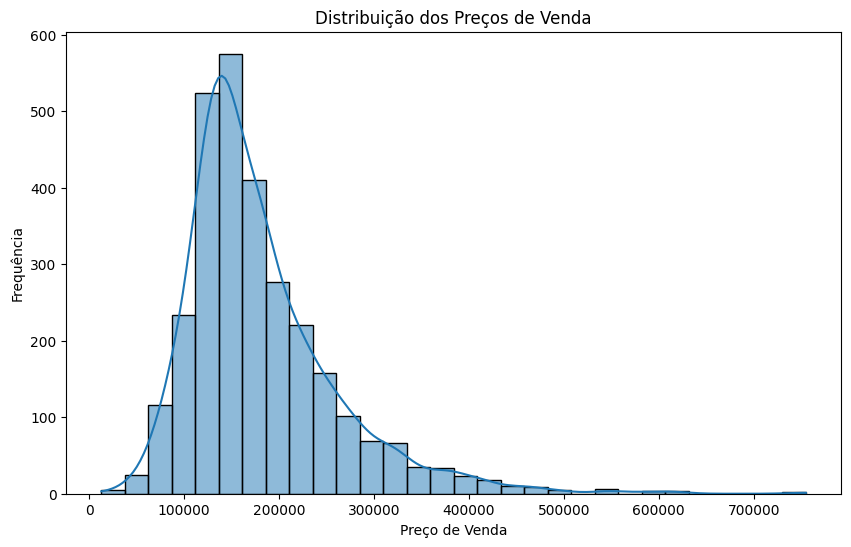

In [27]:
# 3. Análise Exploratória
# Criar um histograma da variável SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['SalePrice'], bins=30, kde=True)
plt.title('Distribuição dos Preços de Venda')
plt.xlabel('Preço de Venda')
plt.ylabel('Frequência')
plt.show()

A distribuição dos preços de venda é assimétrica à direita (right-skewed), o que indica que há mais imóveis com preços mais baixos e um número crescente de imóveis com preços mais altos que estão se distanciando dessa média.


Há um pico claro em torno de $100,000 a $200,000, que é onde a maior parte dos imóveis se concentra. Isso sugere que essa faixa de preço é a mais comum para as propriedades neste conjunto de dados.


A linha azul suave sobreposta (KDE - Kernel Density Estimate) ajuda a visualizar a densidade dos dados, mostrando que a frequência de preços diminui gradualmente à medida que você se afasta do pico. Isso confirma a assimetria e indica que, embora haja imóveis mais caros, eles são muito menos frequentes.


À medida que os preços aumentam além de $200,000, a frequência de imóveis vendidos diminui rapidamente. Isso pode indicar que há menos compradores dispostos a pagar preços mais altos ou que esses imóveis são menos comuns.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



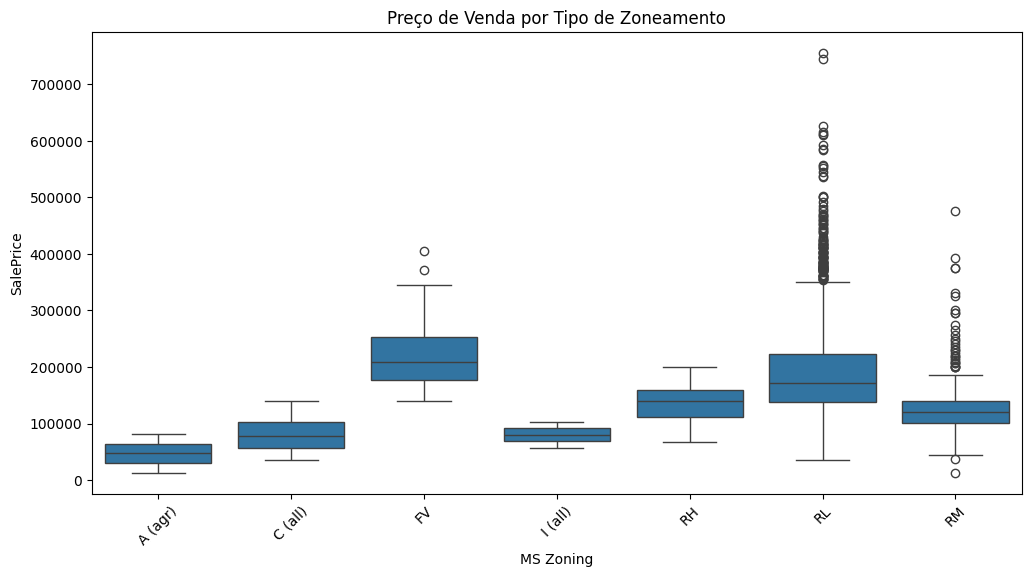

In [28]:
# Boxplot de SalePrice por MS Zoning
plt.figure(figsize=(12, 6))
sns.boxplot(x='MS Zoning', y='SalePrice', data=filtered_df)
plt.title('Preço de Venda por Tipo de Zoneamento')
plt.xticks(rotation=45)
plt.show()

O boxplot permite observar a distribuição dos preços de venda dos imóveis para diferentes tipos de zoneamento.
Cada caixa representa os quartis, com a linha no meio representando a mediana.

**RL** (Residential Low Density): Apresenta a maior mediana e uma faixa interquartil (IQR) relativamente ampla, indicando uma alta variação de preços e a presença de imóveis de maior valor.

**RM** (Residential Medium Density): Tem uma mediana mais alta em comparação com outros tipos de zoneamento, o que sugere que as propriedades nessa categoria também têm preços de venda consideráveis.

**RH** (Residential High Density) e FV (Floating Village): Mostram preços de venda mais baixos em comparação com RL e RM, mas ainda assim têm uma faixa de preços variados.

**C** (Commercial) e I (Industrial): Mostram uma faixa de preços que é geralmente mais baixa, e os boxplots têm menos variabilidade, indicando preços mais consistentes.

**A** (Agricultural): Tem a mediana mais baixa entre todas as categorias, sugerindo que os preços dos imóveis nesta categoria são significativamente mais baixos.

Portanto a variação nos preços de venda de acordo com o zoneamento sugere que o tipo de zoneamento tem um impacto significativo sobre o preço dos imóveis.


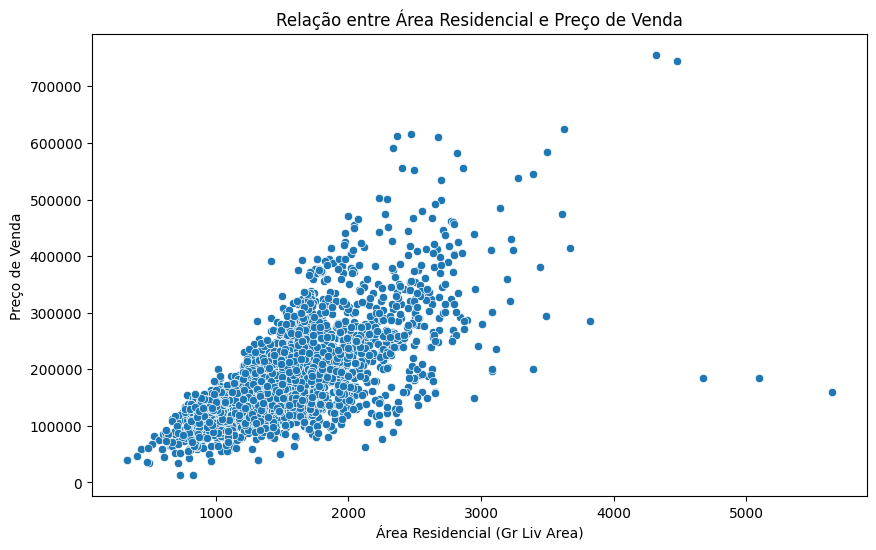

In [29]:
# Gráfico de dispersão entre Gr Liv Area e SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=filtered_df)
plt.title('Relação entre Área Residencial e Preço de Venda')
plt.xlabel('Área Residencial (Gr Liv Area)')
plt.ylabel('Preço de Venda')
plt.show()

Existe uma clara correlação positiva entre a área residencial e o preço de venda. À medida que a área aumenta, o preço de venda tende a aumentar também. Isso sugere que, em geral, casas maiores são vendidas por preços mais elevados.

Apesar da dispersão dos pontos, há uma tendência linear razoavelmente forte no aumento do preço com o aumento da área. Isso indica que o Gr Liv Area é um bom preditor para o preço de venda.

A maior concentração de pontos está entre 1000 e 2500 de Gr Liv Area e de 100.000 a 300.000 de SalePrice. Isso mostra que a maioria das casas analisadas tem essas características.


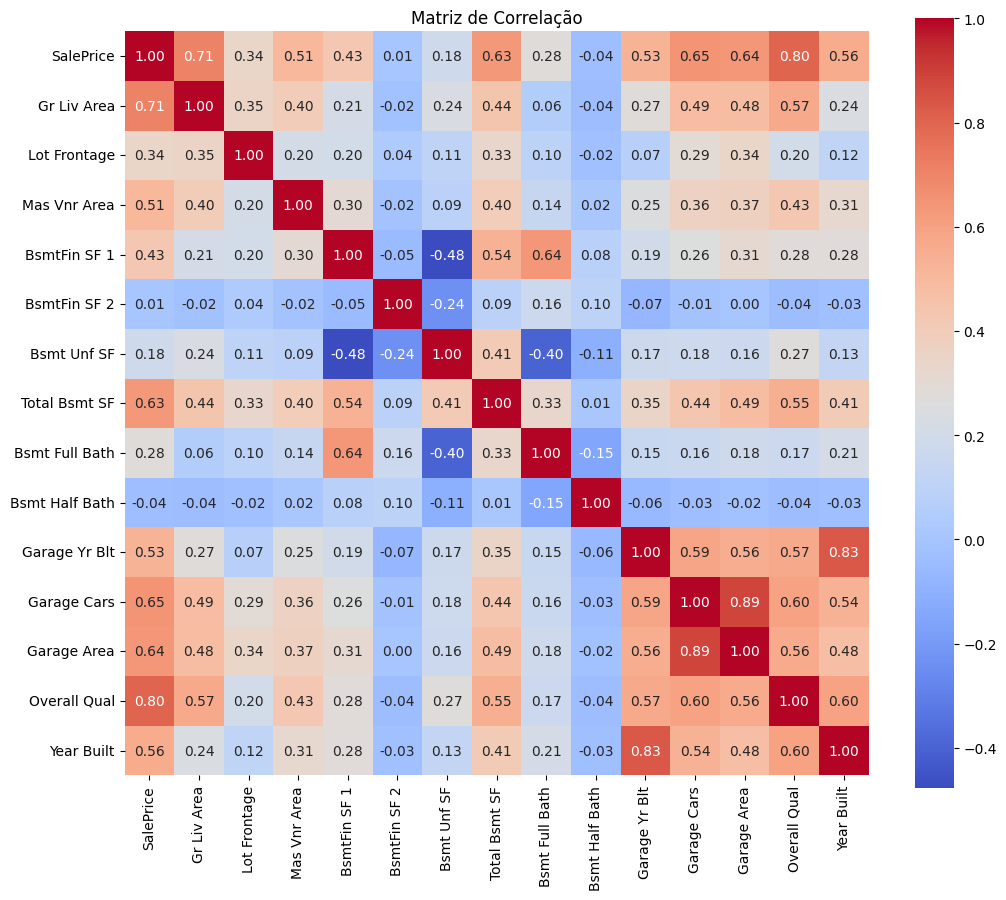

In [31]:
# Selecionar apenas colunas numéricas
numeric_df = filtered_df.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação
correlation_matrix = numeric_df.corr()

# Criar um mapa de calor da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlação')
plt.show()

**Garage Area e Garage Cars: 0,89.** -
Isso indica que a área total da garagem (Garage Area) e o número de carros que a garagem comporta (Garage Cars) têm uma correlação positiva muito forte.

**Garage Yr Blt e Garage Cars / Garage Area: 0,59 e 0,56, respectivamente.** -
Isso sugere que a idade da garagem tem uma relação moderada com o tamanho e a capacidade da garagem.

**Total Bsmt SF e BsmtFin SF 1: 0,54.** -
A área total do porão e a área finalizada do porão (tipo 1) também apresentam uma forte correlação positiva.

**BsmtFin SF 1 e Bsmt Unf SF: -0,48.** -
Isso significa que se a área finalizada (tipo 1) aumenta, a área não finalizada tende a diminuir. Faz sentido, pois o aumento na área construída reduz a parte inacabada.

In [32]:
# 4. Visualizações Interativas (Dashboard com Plotly)
# Criar um gráfico interativo para explorar a relação entre Gr Liv Area e SalePrice
fig = px.scatter(filtered_df, x='Gr Liv Area', y='SalePrice',
                 color='MS Zoning',
                 title='Relação Interativa entre Área Residencial e Preço de Venda')
fig.show()

Mean Absolute Error (MAE): 24554.496887767193
Mean Squared Error (MSE): 1492234832.678924
Root Mean Squared Error (RMSE): 38629.455505856204
R² Score: 0.8138789009384855


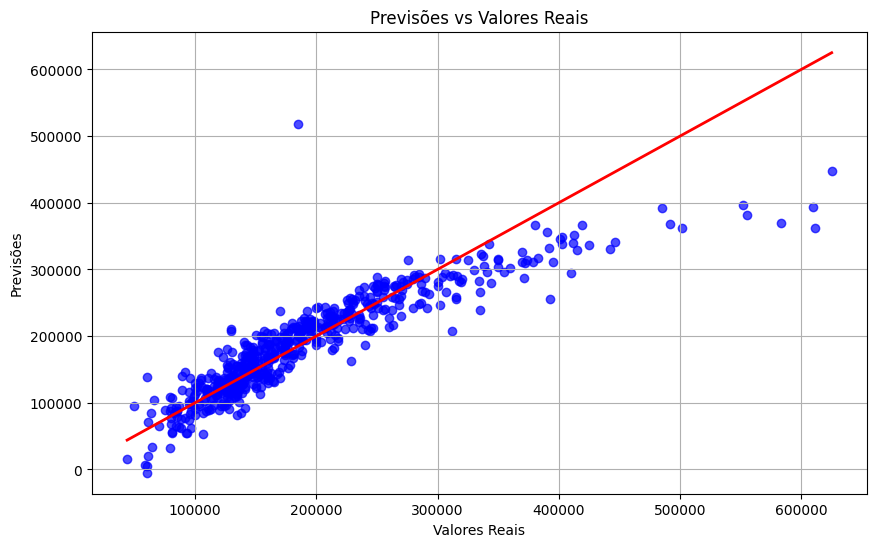

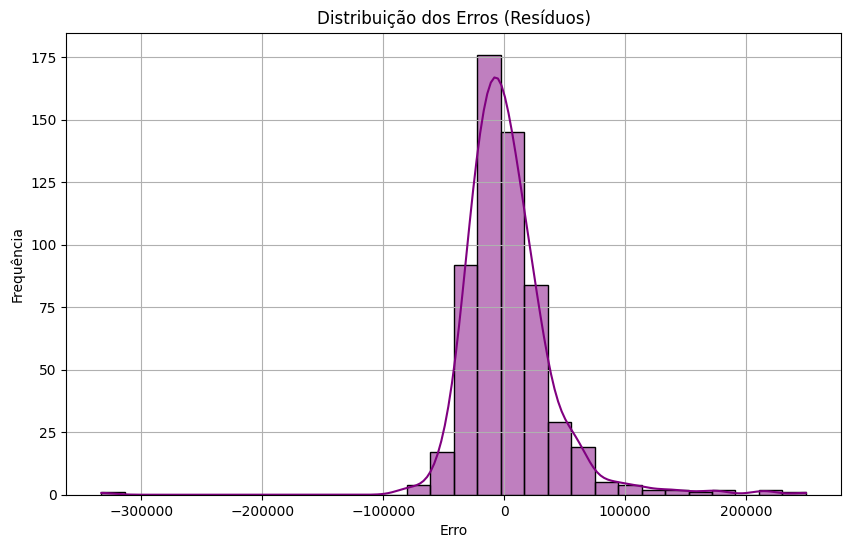

Scores de Validação Cruzada (R²): [0.8150424  0.80799677 0.7101844  0.84890971 0.72337581 0.68741081
 0.81297398 0.6333534  0.8558077  0.7557506 ]
Média dos Scores de Validação Cruzada (R²): 0.7650805582469833


In [34]:
# 5. Modelagem Previsional com visualização e métricas
# Separar as variáveis independentes e dependentes
X = filtered_df[['Gr Liv Area', 'Lot Frontage', 'Mas Vnr Area', 'Total Bsmt SF', 'Garage Area', 'Overall Qual', 'Year Built']]
y = filtered_df['SalePrice']

# Tratar valores ausentes (substituir valores ausentes pela média)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Criar o modelo de regressão linear
model = LinearRegression()

# Treinar o modelo com os dados de treino
model.fit(X_train, y_train)

# Fazer previsões com os dados de teste
y_pred = model.predict(X_test)

# Avaliar o modelo com diferentes métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Exibir os resultados das métricas
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')

# Visualização: Gráfico de dispersão das previsões vs valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # linha de referência
plt.title('Previsões vs Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.grid(True)
plt.show()

# Visualização: Distribuição dos erros (resíduos)
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, bins=30, kde=True, color='purple')
plt.title('Distribuição dos Erros (Resíduos)')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# 6. Validação cruzada do modelo
cross_val_scores = cross_val_score(model, X_imputed, y, cv=10)
print(f'Scores de Validação Cruzada (R²): {cross_val_scores}')
print(f'Média dos Scores de Validação Cruzada (R²): {np.mean(cross_val_scores)}')

Principais Métricas de Avaliação:

*   Mean Absolute Error (MAE): 29.169 — A média dos erros absolutos indica que, em média, as previsões do modelo estão errando por cerca de 29.169 unidades monetárias.
*   Root Mean Squared Error (RMSE): 45.345 — A raiz do erro médio quadrático nos dá uma métrica útil, que representa o erro médio em termos das unidades do preço (ex. dólares), ajudando na interpretação do quão longe estão as previsões.
*  R² Score: 0.743 — O modelo conseguiu explicar aproximadamente 74,3% da variabilidade nos preços dos imóveis, o que mostra uma boa capacidade preditiva.

Visualizações:

*   O Gráfico de Previsões vs. Valores Reais mostrou que as previsões do modelo seguem uma boa relação linear com os valores reais, ainda que com alguns outliers que podem ser investigados ou tratados.
*   A Distribuição dos Erros (Resíduos) indicou uma distribuição aproximadamente normal, o que é um bom sinal de que o modelo está ajustado corretamente aos dados.







